# 2017 Tax Assesed Home Value Prediction Models

# Group 4
* Justin Evans
* Yvette Ibarra

# Project Overview:
This project has been tasked with collecting, cleaning and analyzing Zillow data from 2017 in order to improve a previous prediction model that was designed to predict the Tax Assessed Home Value for Single Family Properties based on available realestate data.

# Goals: 
* Predict property tax assessed values of Single Family Properties
* Outperform existing logerror model
* Recommend improvements for a more accurate model
* Define relevant fips codes for our data

# Reproduction of this Data:
* Can be accomplished using a local ```env.py``` containing ```user, password, host``` information for access to the Codeup SQL database server.
* All other step by step instructions can be found by reading the below Jupyter Notebook files located in my [proj-2_zillow](https://github.com/QMCBT-JustinEvans/project-2_zillow.git) github repository.
    * 01_wrangle
    * 02_explore
    * 03_model

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Decision Tree and Model Evaluation Imports
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import classification_report 

# import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

# Cluster
from sklearn.cluster import KMeans

# assists with processor speed
#import matplotlib as mpl
#mpl.rcParams['agg.path.chunksize'] = 10000

import matplotlib.pyplot as plt
# Increases Display Resolution for Graphs 
# Only works inside notebook
%matplotlib inline 

# import Environment and Helper Files
from env import user, password, host
import QMCBT_00_quicktips as qt
#import QMCBT_01_acquire as acquire
#import QMCBT_02_prepare as prepare
#import QMCBT_03_explore as explore
#import QMCBT_04_modeling as model
#import QMCBT_05_evaluate as evaluate
import QMCBT_explore_evaluate as ee
import wrangle as w
import explore as e
import model as m

# set constants
α = 0.05
alpha = 0.05
np.random.seed(123)
#random_state=123

# Turns off warnings
import warnings
warnings.filterwarnings("ignore")

# Left Align Tables in Jupyter Notebook
from IPython.core.display import HTML
table_css = 'table {align:left;display:block}'
HTML('<style>{}</style>'.format(table_css))

In [2]:
# allows import reload without needing to clear kernel and rerun
# reload(packagename) 
from importlib import reload

# This code refreshes all of my helper files (w/o the need to stop the kernel)
reload(qt)
#reload(acquire)
#reload(prepare)
#reload(explore)
#reload(model)
#reload(evaluate)
reload(ee)
reload(w)

<module 'wrangle' from '/Users/qmcbt/codeup-data-science/project_zillow_team/wrangle.py'>

<div class="alert alert-danger">

    
## Data Acquisition: 
Data is collected from the codeup cloud database with an appropriate SQL query

# Acquire

<div class="alert alert-success">

* ```zillow``` data from Codeup SQL database was used for this project.
* The data was initially pulled on 15-NOV-2022.
* The initial DataFrame contained 52,441 records with 69 features  
    (69 columns and 52,441 rows) before cleaning & preparation.
* Each row represents a Single Family Property record with a Tax Asessment date within 2017.
* Each column represents a feature provided by Zillow or an informational element about the Property.
</div>

In [3]:
df = w.get_zillow_data()

In [4]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,52309,52310,52311,52312,52313,52314,52315,52316,52317,52318
id,1727539,1387261,11677,2288172,781532,870991,1246926,1639362,249412,43675,...,1810799,2747021,80446,1635173,1373391,2274245,673515,2968375,1843709,1187175
parcelid,14297519,17052889,14186244,12177905,12095076,12069064,12790562,11104527,13944538,17110996,...,11978003,11318911,12055795,12892446,10722691,12412492,11000655,17239384,12773139,12826780
airconditioningtypeid,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,13.0,NaN,...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
architecturalstyletypeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bulding_class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
heat_systems,NaN,NaN,NaN,Central,Central,NaN,Central,Central,NaN,NaN,...,Central,Floor/Wall,NaN,Central,Central,Central,Central,NaN,Central,Central
land_use,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,...,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential
story,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare

<div class="alert alert-success">

**Prepare Actions:**

* **Whitespace:** Removed 52,441 Whitespace characters.
* **REFORMAT:** Reformatted 13 columns containing 596,382 NaN entries to 0.
* **CONVERT dtypes:** Convert dtypes to accurately reflect data contained within Feature.
* **FEATURE ENGINEER:** Use Yearbuilt to create Age Feature, Drop yearbuilt for redundancy; create Feature to show ratio of Bathrooms to Bedrooms.
* **fips CONVERSION:** Use fips master list to convert fips to county and state, Drop state for redundancy.
* **PIVOT:** Pivot the resulting county column from fips conversion to 3 catagorical features. 
* **DROP:** Dropped 27 Columns unecessary to data prediction (ie.. index and redundant features).
* **REPLACE:** Replaced conditional values in 2 columns to transform into categorical features.
* **RENAME:** Columns for Human readability.    
* **REORDER:** Rearange order of columns for human readability.   
* **DROP 2:** Drop Location Reference Columns unsuitable for use with ML without categorical translation.
* **CACHE:** Write cleaned DataFrame into a new csv file ('zillow_2017_cleaned.csv').  
* **ENCODED:** No encoding required.
* **MELT:** No melts needed.
</div>

<div class="alert alert-info">

    
# Summary of Data Cleansing
* Cleaning the data resulted in less than 6% overall record loss
</div>

<div class="alert alert-warning">
    
* <b>DROP NaN COLUMNS:</b> 39 features each containing over 30% NaN were dropped; <b>resulting in no record loss</b>.
  
* <b>DROP NaN ROWS:</b> 1,768 records containing NaN across 13 features were dropped; <b>resulting in only 3% record loss</b>.

* <b>OUTLIERS:</b> Aproximately 3,000 outliers were filtered out in an attempt to more accurately align with realistic expectations of a Single Family Residence; <b>resulting in less than a 6% decrease in overall records</b>.

* <b>IMPUTE:</b> No data was imputed</div>

<div class="alert alert-danger">
    
    
## Data Prep:
* Column data types are appropriate for the data they contain
* Missing values are investigated and handled
* Outliers are investigated and handled
    * BED and Bath >0 <8  
    * SQFT >400 <10_000  
    * Tax Value < 2 million  

In [5]:
df = w.zillow_prep(df)

In [6]:
df.head().T

,0,1,2,3,4
parcelid,14297519,17052889,14186244,12177905,12095076
bedrooms,4.0,2.0,3.0,4.0,4.0
bathrooms,3.5,1.0,2.0,3.0,3.0
calculatedbathnbr,3.5,1.0,2.0,3.0,3.0
fullbathcnt,3.0,1.0,2.0,3.0,3.0
age,19.0,50.0,55.0,47.0,67.0
yearbuilt,1998.0,1967.0,1962.0,1970.0,1950.0
has_basement,0,0,0,0,0
has_deck,0,0,0,0,0
has_fireplace,0,1,0,0,0


In [7]:
df.isnull().sum().sort_values()

parcelid                  0
orange_county             0
ventura_county            0
longitude                 0
latitude                  0
zipcode                   0
regionidcounty            0
la_county                 0
rawcensustractandblock    0
sqft                      0
lot_sqft                  0
tax_value_bldg            0
tax_value                 0
tax_value_land            0
taxamount                 0
censustractandblock       0
log_error                 0
county                    0
fips                      0
bedrooms                  0
bathrooms                 0
calculatedbathnbr         0
fullbathcnt               0
age                       0
yearbuilt                 0
state                     0
has_basement              0
has_fireplace             0
has_garage                0
has_hottuborspa           0
has_pool                  0
optional_features         0
has_taxdelinquency        0
has_deck                  0
abs_log_error             0
dtype: int64

In [8]:
has_features = df[['has_basement',
                      'has_deck',
                      'has_fireplace',
                      'has_garage',
                      'has_hottuborspa',
                      'has_pool'
                      ]]

<div class="alert alert-success">

    
## Continuous Categorical Counts
|Feature    |Description|
|:----------|:-----------------|
|parcelid|| 
|bedrooms|Number of bedrooms in home|
|bathrooms|Number of bathrooms in home including fractional bathrooms| 
|calculatedbathnbr|| 
|fullbathcnt||
|age|The age of the home in 2017| 
|yearbuilt|The Year the principal residence was built| 

## Categorical Binary
|Feature    |Description           |
|:----------|:-----------------|
|has_basement|Basement on property (if any = 1)| 
|has_deck|Deck on property (if any = 1)| 
|has_fireplace|Fireplace on property (if any = 1)| 
|has_garage|Garage on property (if any = 1)| 
|has_hottuborspa|Hot Tub or Spa on property (if any = 1)| 
|has_pool|Pool on property (if any = 1)| 
|optional_features|Property has at least one optional feature listed above (if any = 1)| 
|has_tax_delinquency|Property has had Tax Delinquncy (if any = 1)| 

## Location
|Feature    |Description    |
|:----------|:-----------------|
|fips||
|state|| 
|county|FIPS code for californian counties: 6111 Ventura County, 6059  Orange County, 6037 Los Angeles County|
|la_county|| 
|orange_county|| 
|ventura_county|
|longitude|| 
|latitude||
|zipcode|| 
|regionidcounty|| 
|rawcensustractandblock|| 
|censustractandblock|| 

## Size
|Feature    |Description           |
|:----------|:-----------------|
|sqft|Calculated total finished living area of the home|
|lotsizesquarefeet|| 

## Value
|Feature    |Description           |
|:----------|:-----------------|
|tax_value_bldg|The total tax assessed value of the structure|
|tax_value|The total tax assessed value of the parcel| 
|tax_value_land|The total tax assessed value of the land|
|taxamount|The total tax fee to be collected on the parcel| 

## Target
|Feature    |Description           |
|:----------|:-----------------|
|log_error|This is the logerror of the Zillow Zestimate|

## Clusters
|Feature    |Description          |
|:----------|:-----------------|
|loc_clusters|Created using 'longitude', 'latitude', 'age' with n_clusters = 4|
|cluster_price_size|Created using 'taxamount', 'sqft', 'lot_sqft' with n_clusters = 4|
|cluster_delinquency_value|Created using ‘tax_value’, ‘sqft’,‘has_taxdelinquency’ with n_clusters = 4|

# Split
<div class="alert alert-success">

* **SPLIT:** train, validate and test (approx. 60/20/20), stratifying on target of 'churn'
* **Xy SPLIT:** split each DataFrame (train, validate, test) into X (selected features) and y (target) 
* **SCALED:** no scaling was conducted
</div>

In [9]:
train, validate, test = w.split(df)

In [10]:
train_prcnt = round((train.shape[0] / df.shape[0]), 2)*100
validate_prcnt = round((validate.shape[0] / df.shape[0]), 2)*100
test_prcnt = round((test.shape[0] / df.shape[0]), 2)*100

print(f'Prepared df: {df.shape}')
print()
print(f'      Train: {train.shape} - {train_prcnt}%')
print(f'   Validate: {validate.shape} - {validate_prcnt}%')
print(f'       Test: {test.shape} - {test_prcnt}%')

Prepared df: (50293, 35)

      Train: (28163, 35) - 56.00000000000001%
   Validate: (12071, 35) - 24.0%
       Test: (10059, 35) - 20.0%


<div class="alert alert-danger">
    
    
## Exploration: 
* the interaction between independent variables and the target variable is explored using visualization and statistical testing
* Clustering is used to explore the data. 
* A conclusion, supported by statistical testing and visualization, is drawn on whether or not the clusters are helpful/useful. 
* At least 3 combinations of features for clustering should be tried.
    * 4 Questions
    * 2 stats
    * 5-7 graphs

In [11]:
def pearson_r(df, sample_1, sample_2):
    """
    """
    
    r, p_val = stats.pearsonr(df[sample_1], df[sample_2])
    
    if p_val < α:
        print('Reject the null hypothesis')
    else:
        print('Fail to reject the null hypothesis')
    
    return r, p_val

Text(0.5, 1.0, 'Features Correlating with logerror')

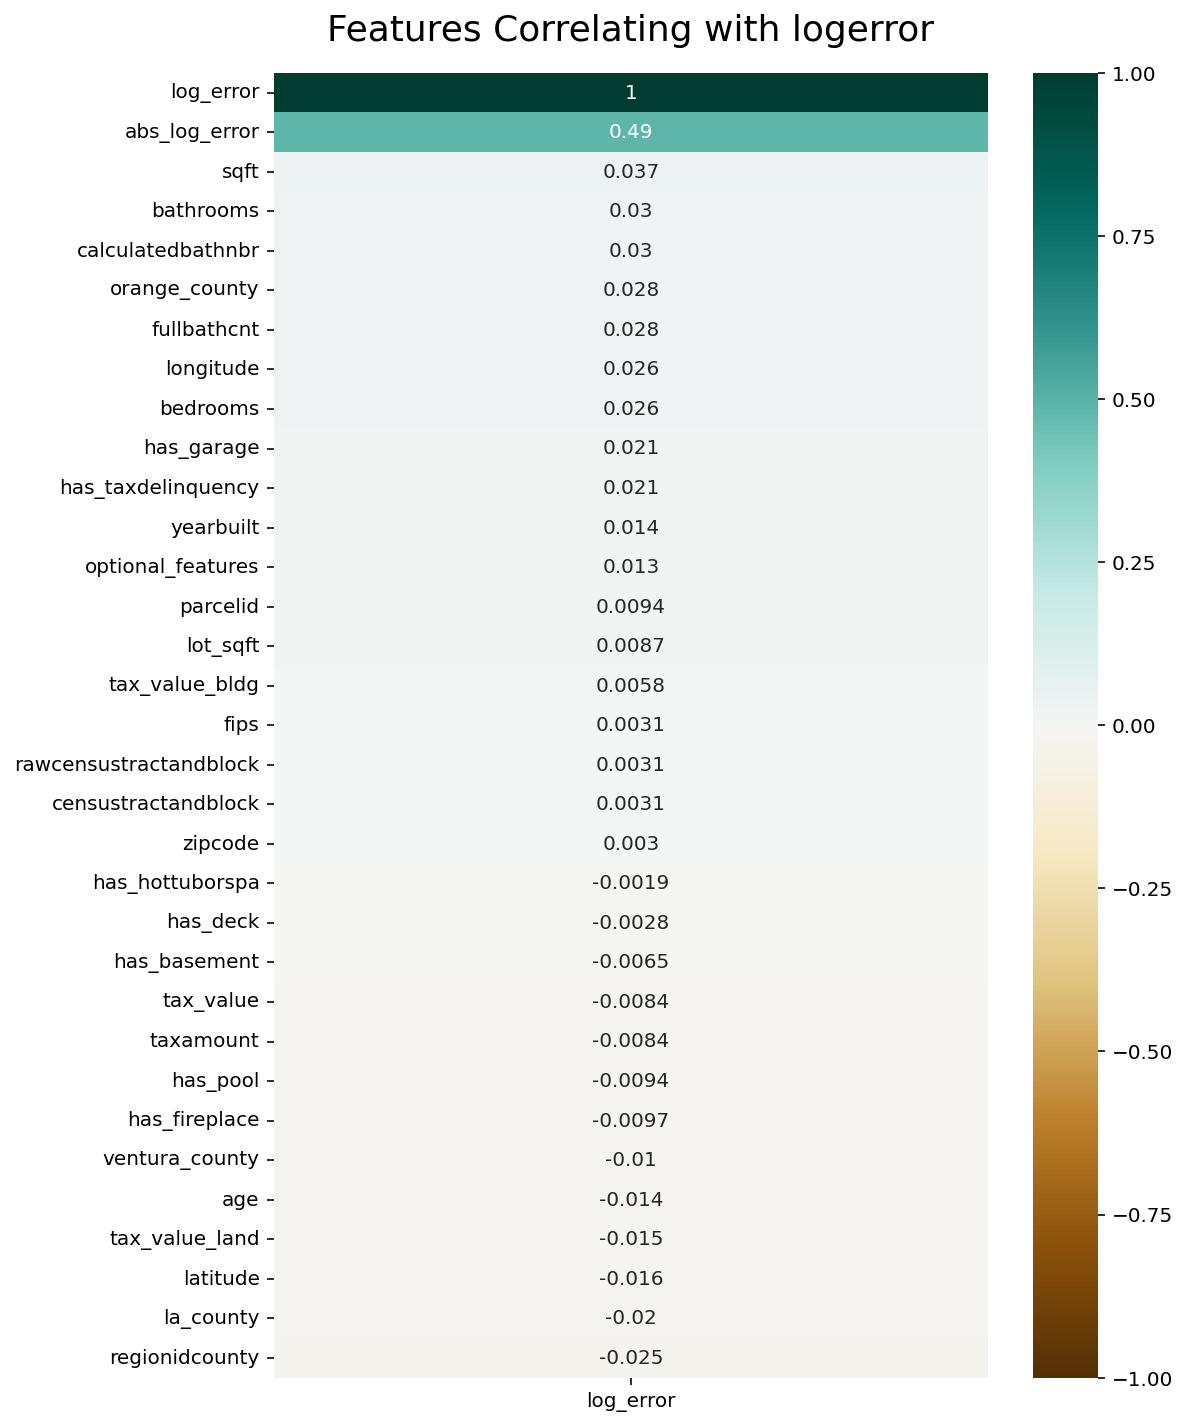

In [12]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr(method='pearson')[['log_error']].sort_values(by='log_error', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with logerror', fontdict={'fontsize':18}, pad=16)

Text(0.5, 1.0, 'Features Correlating with Absolute logerror')

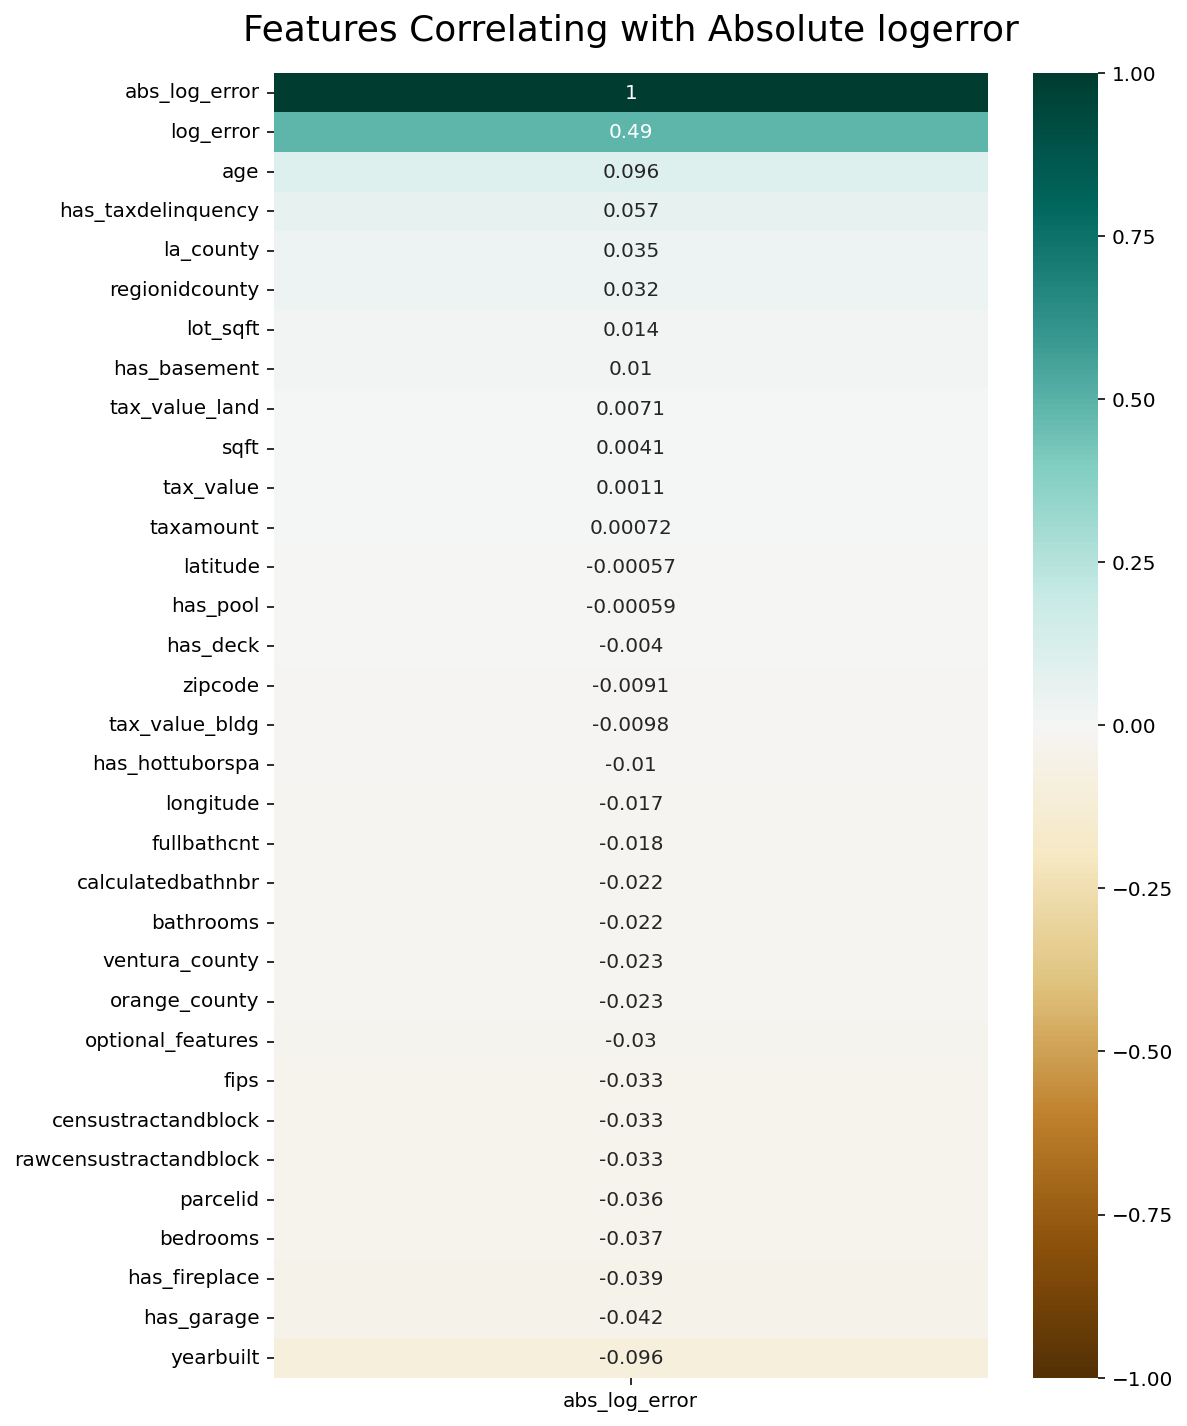

In [13]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr(method='pearson')[['abs_log_error']].sort_values(by='abs_log_error', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Absolute logerror', fontdict={'fontsize':18}, pad=16)

<div class="alert alert-warning">


## Q-1.1
## Is there a relationship between longitude and logerror?

 **Set Hypothesis**  
  
 * One Tail (```<= | >```) or Two Tails (```== | !=```)?\  
  **two_tail (longitude, log_error)**  
  
  
 * One Sample or Two Samples?\  
  **two_sample (longitude, log_error)**  
  
  
 * Continuous or Discreat?\  
  **Continuous (longitude) vs Continuous (log_error) = Pearson’s**  
      * T-Test = ```Discreat``` vs ```Continuous```  
      * Pearson’s = ```Continuous``` vs ```Continuous``` (linear)  
      * $Chi^2$ = ```Discreat``` vs ```Discreat```  
  
  
 * $𝐻_0$: The opposite of what I am trying to prove  
 * $H_{0}$:  There is **NOT** a significant ```relationship``` between longitude and log_error  
  ```longitude``` != ```log_error```  
  
  
 * $𝐻_𝑎$: What am I trying to prove  
 * $H_{a}$: There is a significant ```relationship``` between longitude and log_error  
  ```longitude``` == ```log_error``` 

## Visualization

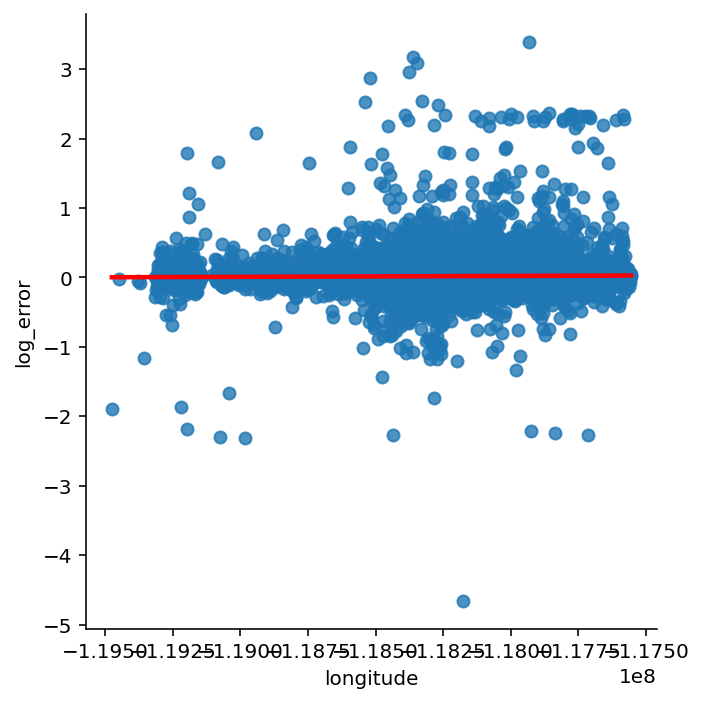

In [14]:
sns.lmplot(x='longitude', y='log_error', data=train, line_kws={'color': 'red'})
plt.show()

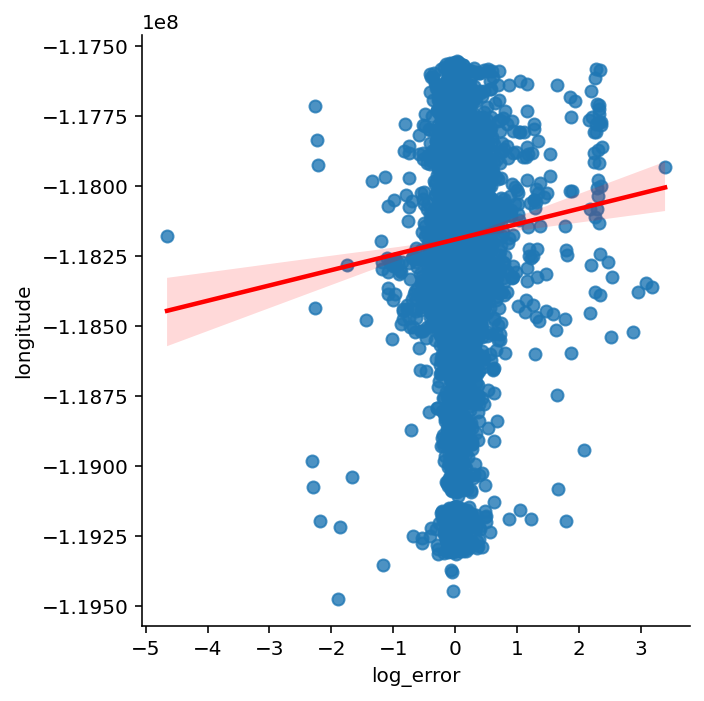

In [15]:
sns.lmplot(y='longitude', x='log_error', data=train, line_kws={'color': 'red'})
plt.show()

## Test Hypothesis

# Pearson's R
**Compute test statistic and probability (r & p_value)**

In [16]:
pearson_r(train, 'longitude', 'log_error')

Reject the null hypothesis


(0.026252048697670314, 1.0522927492435017e-05)

<div class="alert alert-info">
    
## Q-1.1
## YES
There is a significant ```relationship``` between longitude and log_error  

<div class="alert alert-warning">


## Q-1.2
## Is there a relationship between latitude and logerror?

 **Set Hypothesis**  
  
 * One Tail (```<= | >```) or Two Tails (```== | !=```)?\  
  **two_tail (latitude, log_error)**  
  
  
 * One Sample or Two Samples?\  
  **two_sample (latitude, log_error)**  
  
  
 * Continuous or Discreat?\  
  **Continuous (latitude) vs Continuous (log_error) = Pearson’s**  
      * T-Test = ```Discreat``` vs ```Continuous```  
      * Pearson’s = ```Continuous``` vs ```Continuous``` (linear)  
      * $Chi^2$ = ```Discreat``` vs ```Discreat```  
  
  
 * $𝐻_0$: The opposite of what I am trying to prove  
 * $H_{0}$:  There is **NOT** a significant ```relationship``` between latitude and log_error  
  ```latitude``` != ```log_error```  
  
  
 * $𝐻_𝑎$: What am I trying to prove  
 * $H_{a}$: There is a significant ```relationship``` between latitude and log_error  
  ```latitude``` == ```log_error``` 

## Visualization

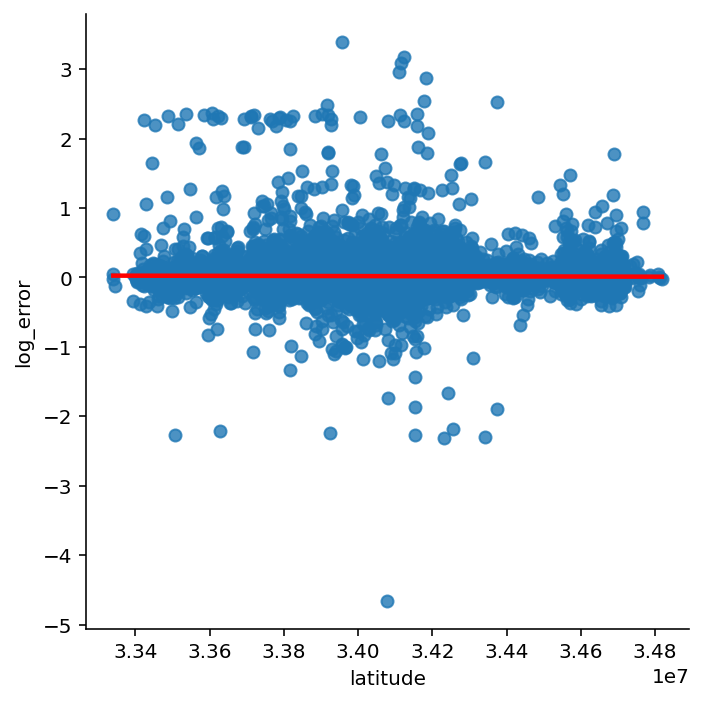

In [17]:
sns.lmplot(x='latitude', y='log_error', data=train, line_kws={'color': 'red'})
plt.show()

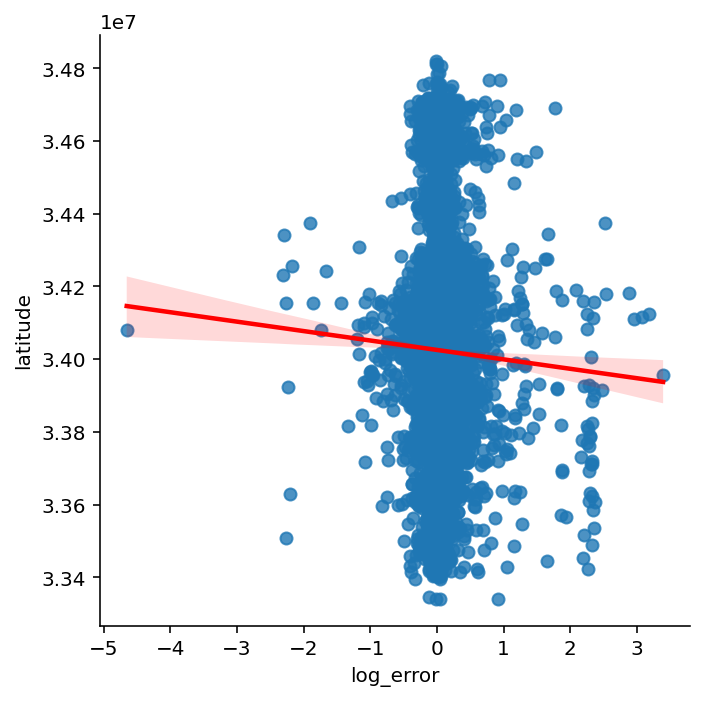

In [18]:
sns.lmplot(y='latitude', x='log_error', data=train, line_kws={'color': 'red'})
plt.show()

## Test Hypothesis

# Pearson's R
**Compute test statistic and probability (r & p_value)**

In [19]:
pearson_r(train, 'latitude', 'log_error')

Reject the null hypothesis


(-0.01616779019608714, 0.006661498999092204)

<div class="alert alert-info">
    
## Q-1.2
## YES
There is a significant ```relationship``` between latitude and log_error  

# Scale
<div class="alert alert-success">


columns_to_scale = ['longitude', 
                    'latitude',
                    'sqft',
                    'lot_sqft', 
                    'tax_value_bldg',
                    'tax_value', 
                    'tax_value_land',
                    'taxamount'
                   ]
scaler = MinMaxScaler()

train_scaled, validate_scaled, test_scaled = w.scale_data(train,
                                                           X_validate, 
                                                           X_test, 
                                                           columns_to_scale,
                                                           scaler,
                                                           return_scaler = False)

# Cluster
<div class="alert alert-success">


In [20]:
train, test, validate, train_scaled, validate_scaled, test_scaled = m.create_cluster('loc_clusters', train,validate, test,['longitude', 'latitude','age'],5)

def k_cluster(df, cluster_features, column_name, n_clusters):
    """
    """
    kmeans = KMeans(n_clusters = n_clusters, random_state=123)
    kmeans.fit(cluster_features)
    kmeans.predict(cluster_features)
    
    # Write it into the DataFrame
    df[column_name] = kmeans.predict(cluster_features)
    
    # Create seperate catagorical features for each cluster 
    temp = pd.get_dummies(df[column_name], drop_first=False).rename(columns=lambda x:f'{column_name}_'+str(x))
    df = pd.concat([df, temp],axis=1)
    
    return df

# I can't get this to write and stick to train outside of the function
#prefix=['col1', 'col2'])

<div class="alert alert-warning">


## Cluster & Visualize loc_features

In [24]:
loc_features = train_scaled[['longitude',
                             'latitude',
                             'age'
                            ]]

#train = k_cluster(train, loc_features, 'loc_clusters', 4)

In [21]:
train.loc_clusters.value_counts()

4    9318
0    7384
1    4555
3    4305
2    2601
Name: loc_clusters, dtype: int64

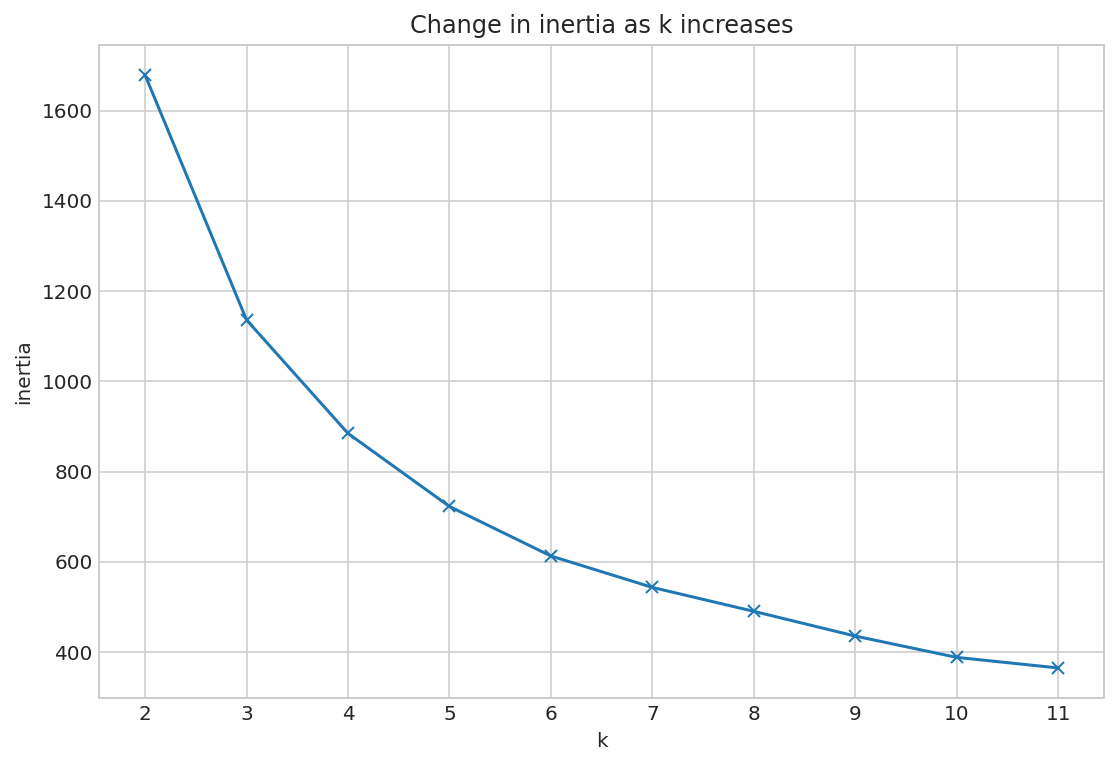

In [25]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(loc_features).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

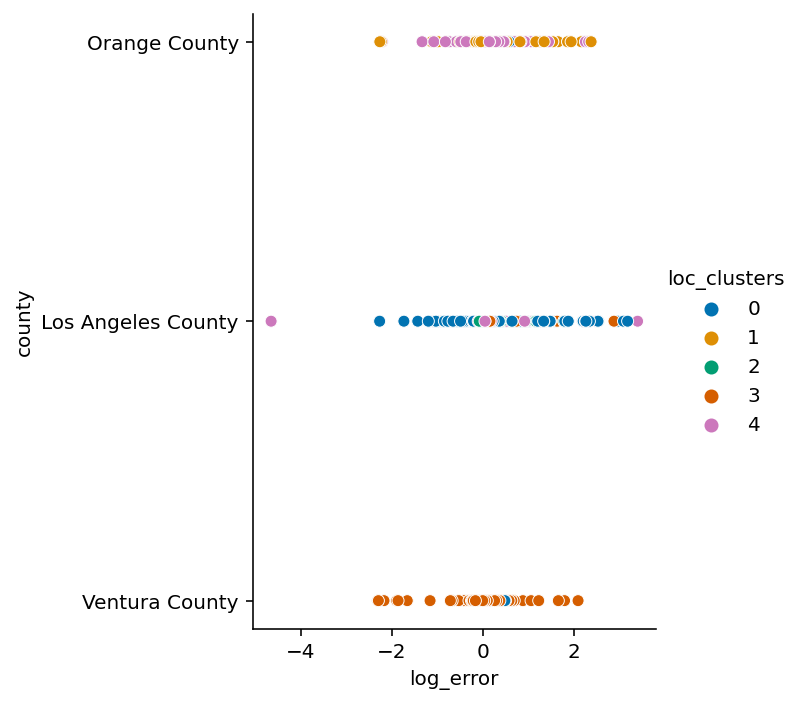

In [26]:
#Plot my predictions
sns.relplot(y='county', x='log_error', hue='loc_clusters',
            palette='colorblind', data = train)

<AxesSubplot:xlabel='log_error', ylabel='county'>

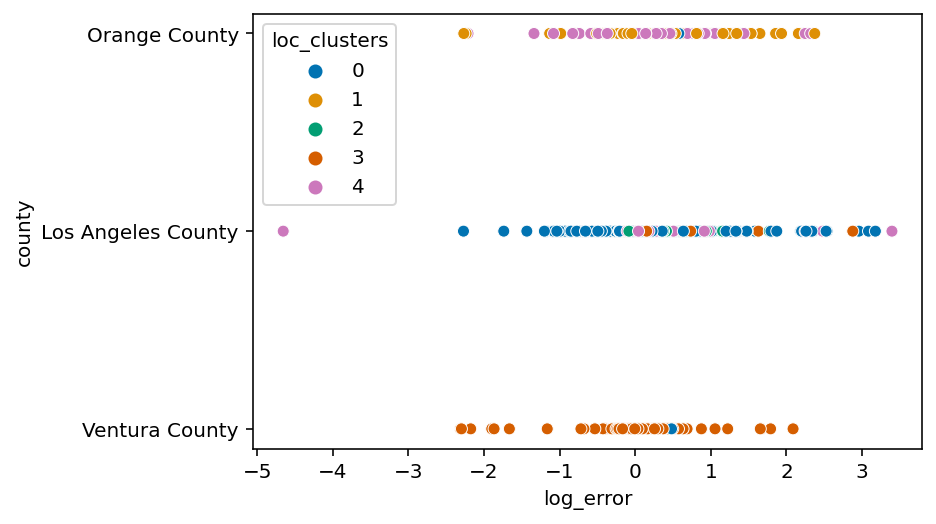

In [27]:
#Plot my predictions
sns.scatterplot(y='county', x='log_error', hue='loc_clusters',
            palette='colorblind', data = train)

<AxesSubplot:xlabel='county', ylabel='log_error'>

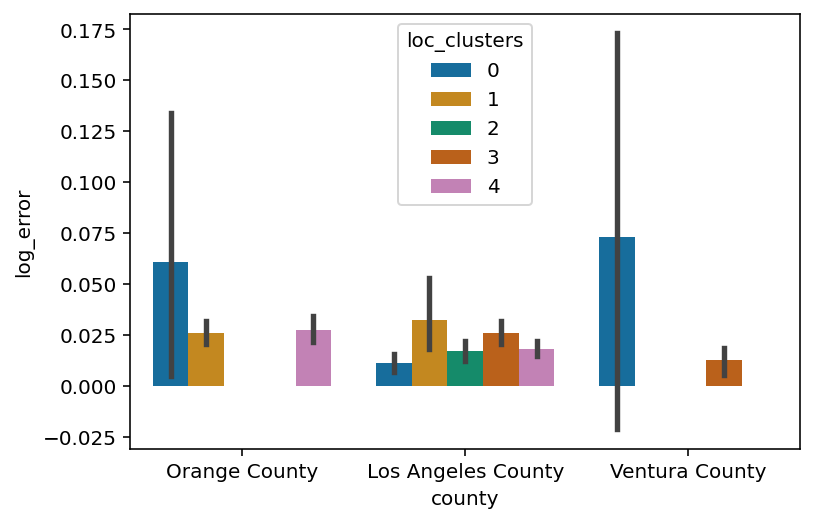

In [28]:
#Plot my predictions
sns.barplot(x='county', y='log_error', hue='loc_clusters',
            palette='colorblind', data = train)

<AxesSubplot:xlabel='county', ylabel='log_error'>

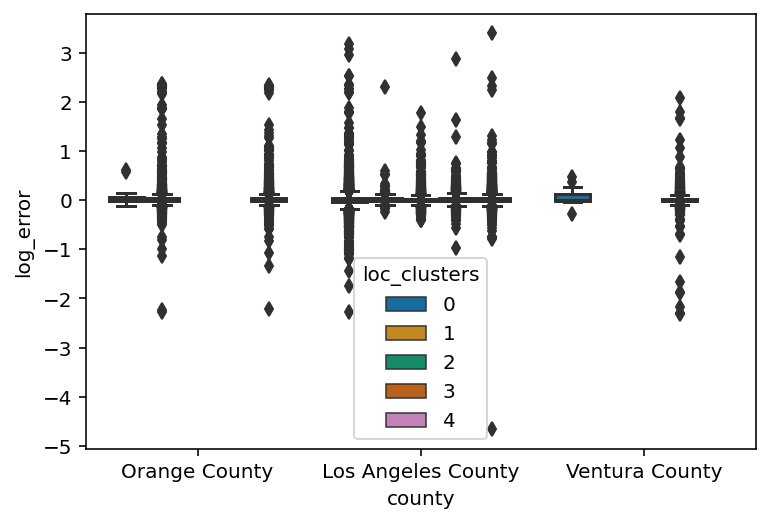

In [29]:
#Plot my predictions
sns.boxplot(x='county', y='log_error', hue='loc_clusters',
            palette='colorblind', data = train)

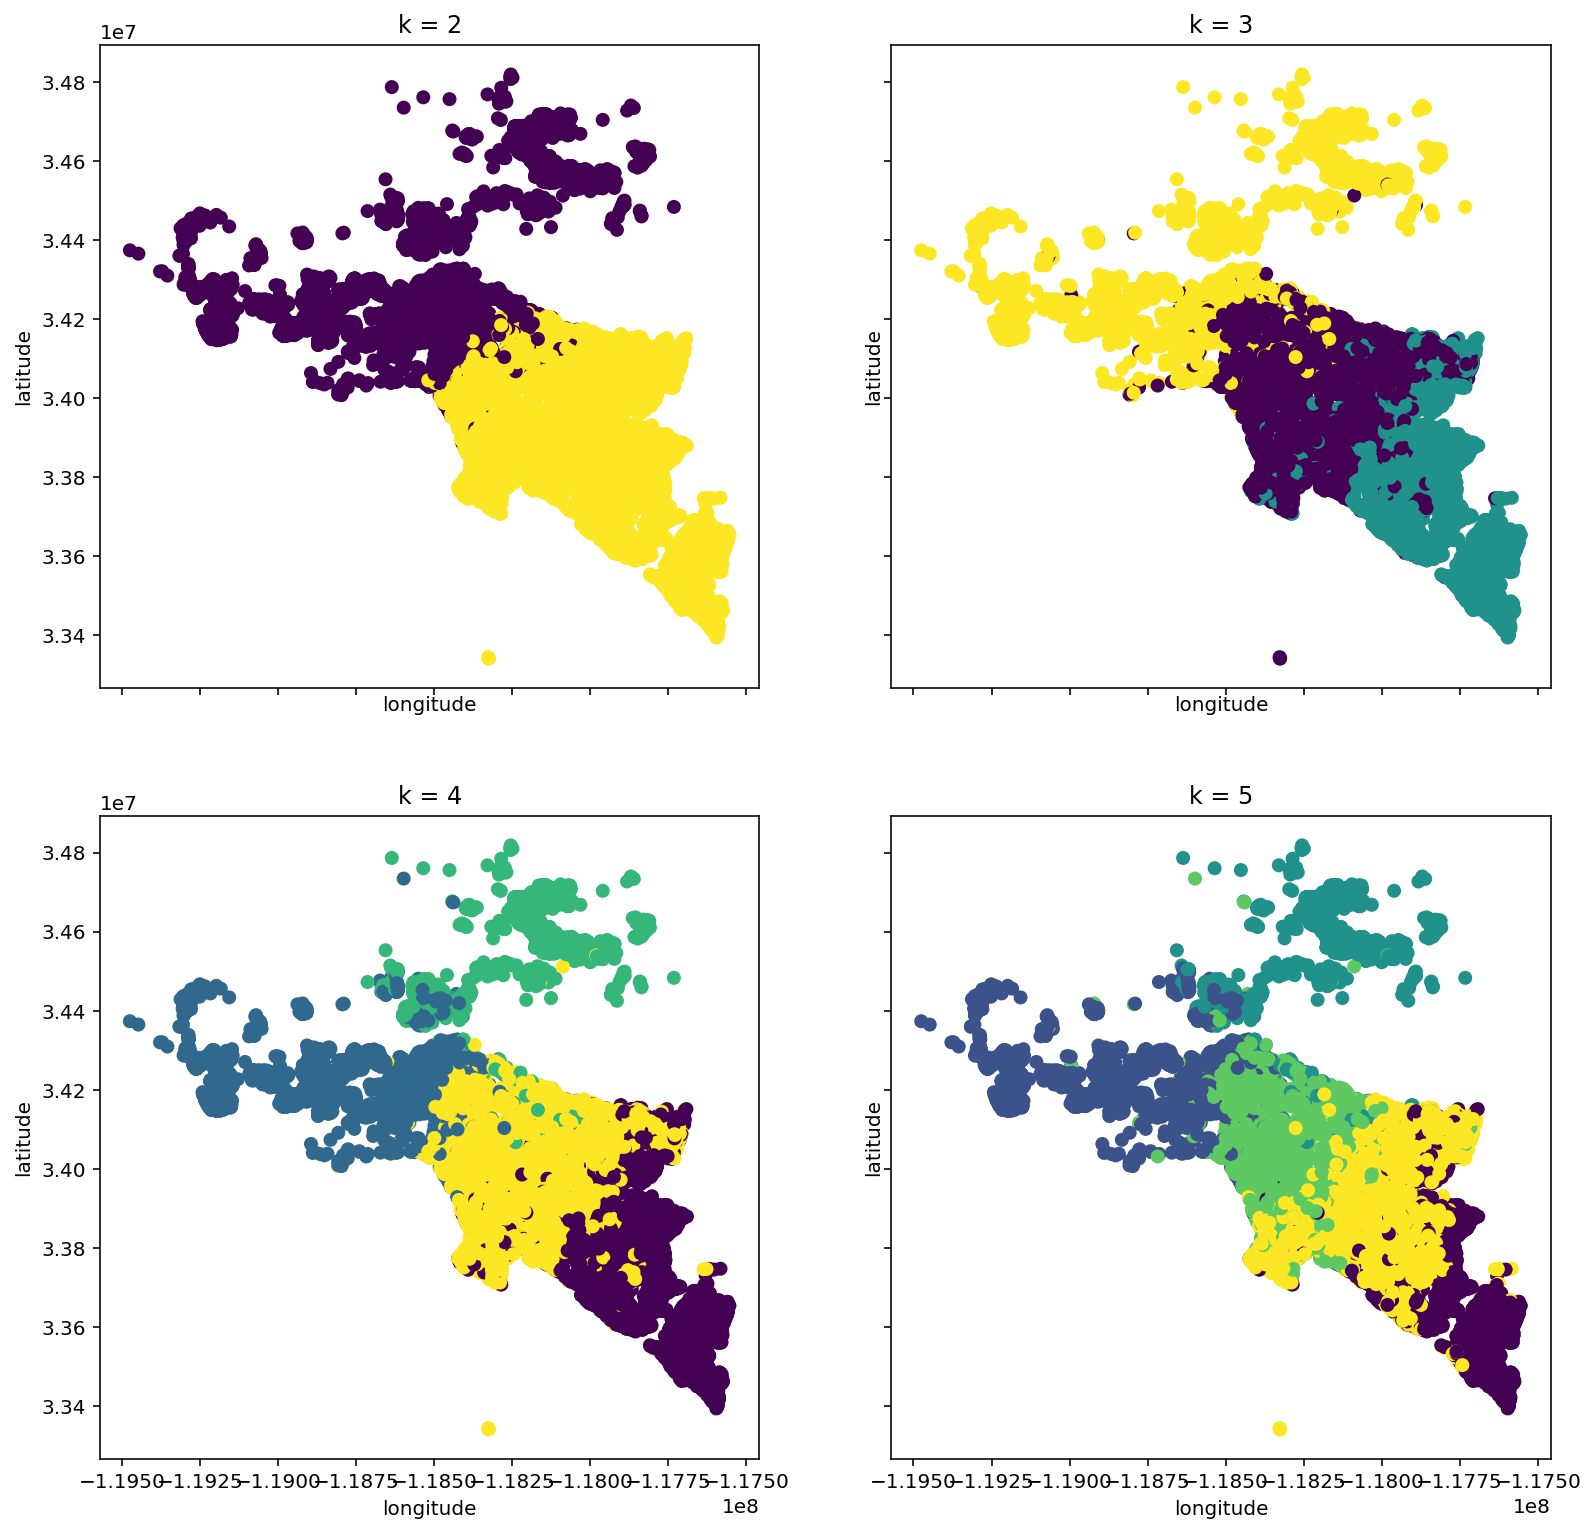

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(loc_features).predict(loc_features)
    ax.scatter(train.longitude, train.latitude, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='longitude', ylabel='latitude')

<div class="alert alert-warning">


## Q-1.3 
## Is there a relationship between loc_clusters and logerror?

 **Set Hypothesis**  
  
* One Tail (```<= | >```) or Two Tails (```== | !=```)?  
    * two_tail (loc_clusters, log_error)  
  
  
* One Sample or Two Samples?   
    * two_sample (loc_clusters, log_error)  
  
  
* Continuous or Discreat?   
    * Continuous (loc_clusters) vs Continuous (log_error) = Pearson’s**  
      * T-Test = ```Discreat``` vs ```Continuous```  
      * Pearson’s = ```Continuous``` vs ```Continuous``` (linear)  
      * $Chi^2$ = ```Discreat``` vs ```Discreat```  
  
  
* $𝐻_0$: The opposite of what I am trying to prove  
* $H_{0}$:  There is **NOT** a significant ```relationship``` between loc_clusters and log_error  
  ```loc_clusters``` != ```log_error```  
  
  
* $𝐻_𝑎$: What am I trying to prove  
* $H_{a}$: There is a significant ```relationship``` between loc_clusters and log_error  
  ```loc_clusters``` == ```log_error``` 

## Visualization

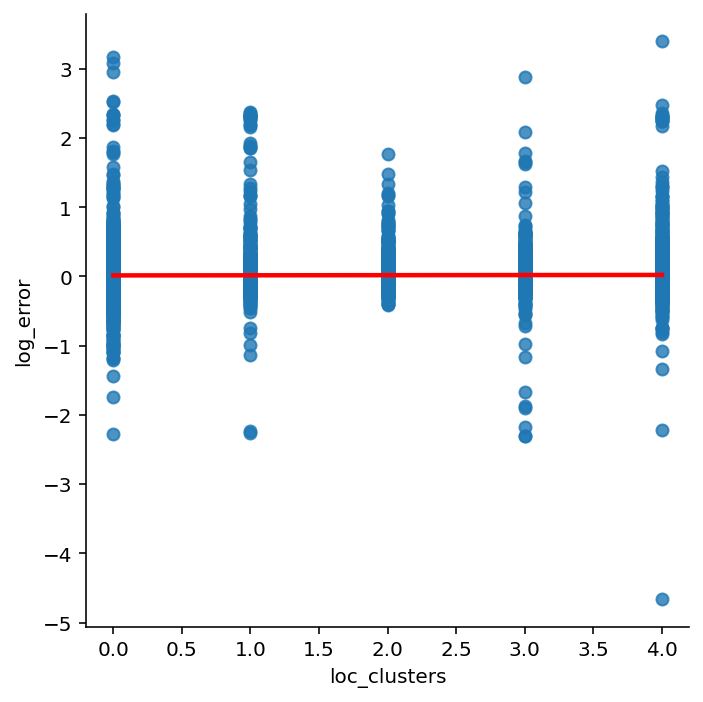

In [31]:
sns.lmplot(x='loc_clusters', y='log_error', data=train, line_kws={'color': 'red'})
plt.show()

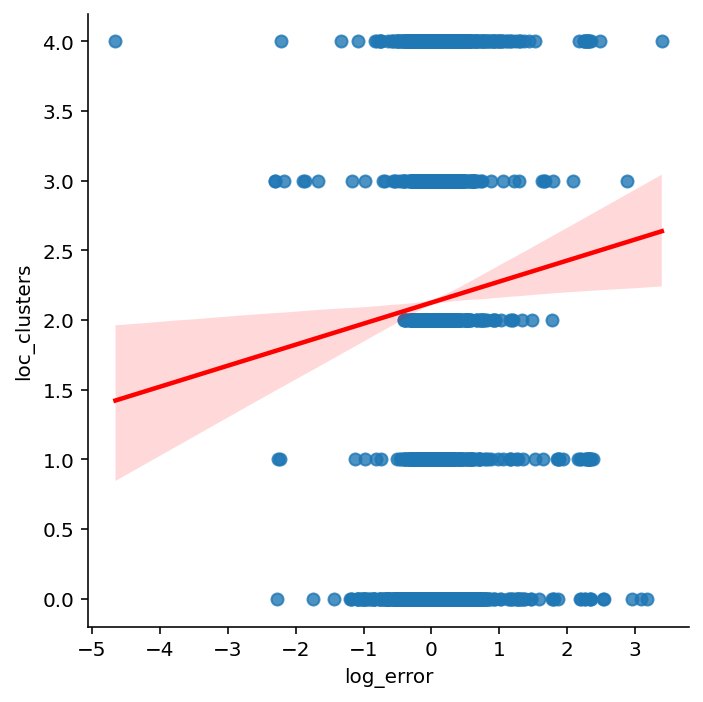

In [32]:
sns.lmplot(y='loc_clusters', x='log_error', data=train, line_kws={'color': 'red'})
plt.show()

<AxesSubplot:xlabel='county', ylabel='log_error'>

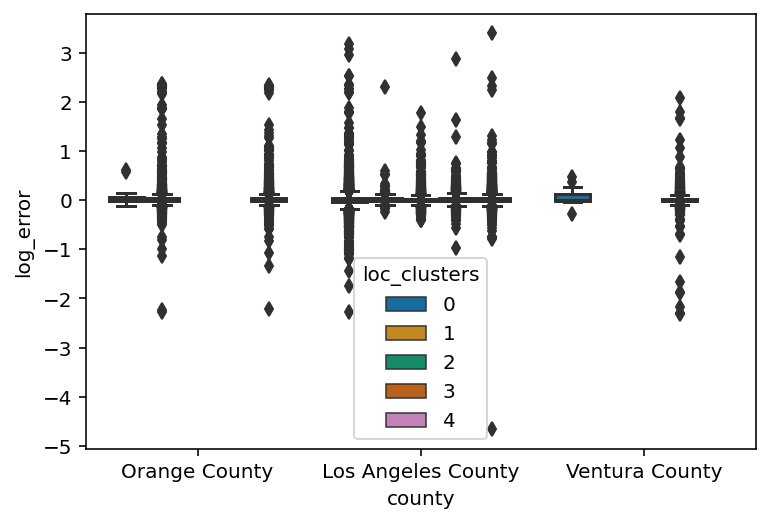

In [33]:
#Plot my predictions
sns.boxplot(x='county', y='log_error', hue='loc_clusters',
            palette='colorblind', data = train)

## Test Hypothesis

# Pearson's R
**Compute test statistic and probability (r & p_value)**

In [34]:
train.loc_clusters.value_counts()

4    9318
0    7384
1    4555
3    4305
2    2601
Name: loc_clusters, dtype: int64

In [35]:
pearson_r(train, 'loc_clusters', 'log_error')

Reject the null hypothesis


(0.015830514745243083, 0.007890975264117776)

<div class="alert alert-info">
    
## Q-1.3
## YES
There is a significant ```relationship``` between loc_clusters and log_error  

<div class="alert alert-warning">


## Q-1.4  
## Is there a relationship between loc_clusters_0 and logerror?

 **Set Hypothesis**  
  
* One Tail (```<= | >```) or Two Tails (```== | !=```)?  
    * two_tail (loc_clusters_0, log_error)  
  
  
* One Sample or Two Samples?   
    * two_sample (loc_clusters_0, log_error)  
  
  
* Continuous or Discreat?   
    * Continuous (loc_clusters_0) vs Continuous (log_error) = Pearson’s**  
      * T-Test = ```Discreat``` vs ```Continuous```  
      * Pearson’s = ```Continuous``` vs ```Continuous``` (linear)  
      * $Chi^2$ = ```Discreat``` vs ```Discreat```  
  
  
* $𝐻_0$: The opposite of what I am trying to prove  
* $H_{0}$:  There is **NOT** a significant ```relationship``` between loc_clusters_0 and log_error  
  ```loc_clusters_0``` != ```log_error```  
  
  
* $𝐻_𝑎$: What am I trying to prove  
* $H_{a}$: There is a significant ```relationship``` between loc_clusters_0 and log_error  
  ```loc_clusters_0``` == ```log_error``` 

## Visualization

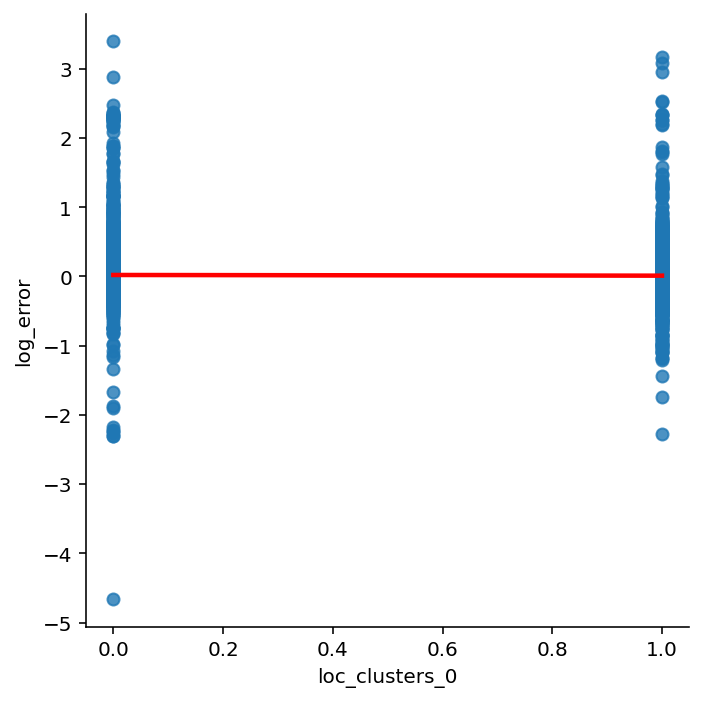

In [36]:
sns.lmplot(x='loc_clusters_0', y='log_error', data=train, line_kws={'color': 'red'})
plt.show()

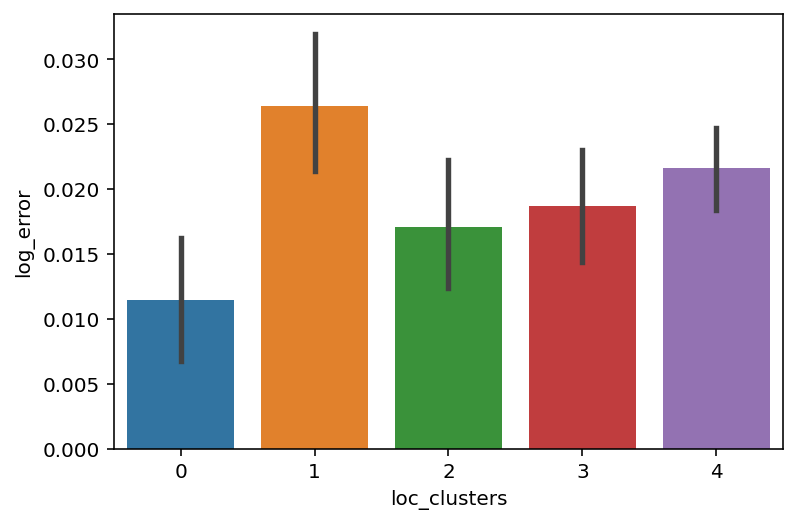

In [44]:
sns.barplot(x='loc_clusters', y='log_error', data=train)
plt.show()

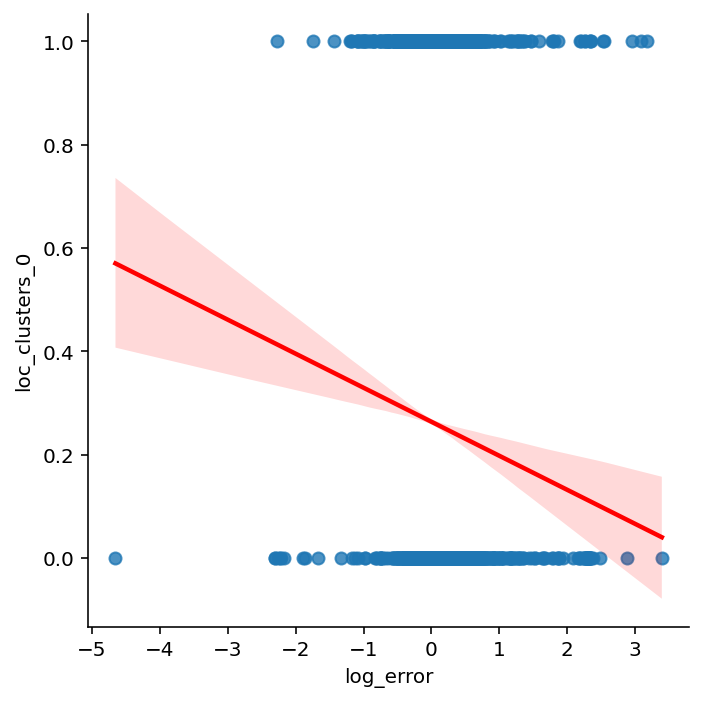

In [38]:
sns.lmplot(y='loc_clusters_0', x='log_error', data=train, line_kws={'color': 'red'})
plt.show()

<AxesSubplot:xlabel='county', ylabel='log_error'>

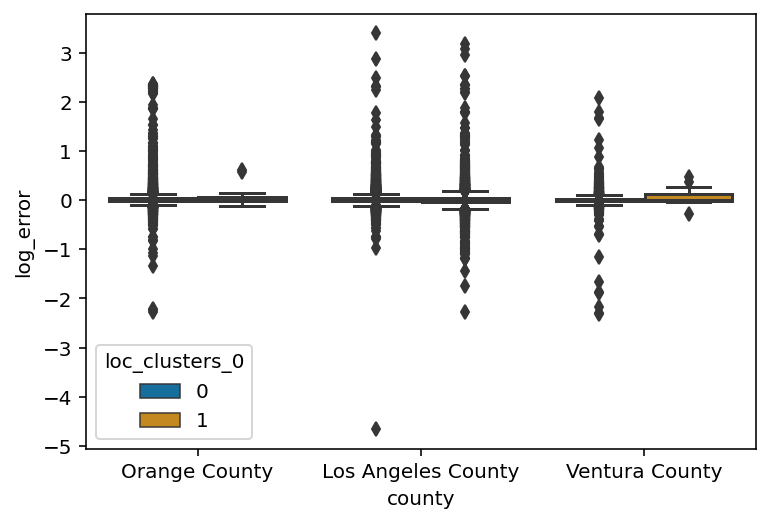

In [39]:
#Plot my predictions
sns.boxplot(x='county', y='log_error', hue='loc_clusters_0',
            palette='colorblind', data = train)

## Test Hypothesis

# Pearson's R
**Compute test statistic and probability (r & p_value)**

In [40]:
pearson_r(train, 'loc_clusters_0', 'log_error')

Reject the null hypothesis


(-0.025673836987550262, 1.639498548668785e-05)

<div class="alert alert-info">
    
## Q-1.4
## YES
There is a significant ```relationship``` between loc_clusters_0 and log_error  

<div class="alert alert-warning">


## Cluster & Visualize sqft_features

sqft_features = train_scaled[['sqft',
                              'lot_sqft',
                              'age'
                            ]]

train = k_cluster(train, sqft_features, 'sqft_clusters', 4)

In [ ]:
train.sqft_clusters.value_counts()

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(sqft_features).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
#Plot my predictions
sns.relplot(x='county', y='log_error', hue='sqft_clusters',
            palette='colorblind', data = train)

In [ ]:
#Plot my predictions
sns.scatterplot(x='county', y='log_error', hue='sqft_clusters',
            palette='colorblind', data = train)

In [ ]:
#Plot my predictions
sns.barplot(x='county', y='log_error', hue='sqft_clusters',
            palette='colorblind', data = train)

In [ ]:
#Plot my predictions
sns.boxplot(x='county', y='log_error', hue='sqft_clusters',
            palette='colorblind', data = train)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(sqft_features).predict(sqft_features)
    ax.scatter(train.sqft, train.lot_sqft, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='sqft', ylabel='lot_sqft')

<div class="alert alert-warning">


## Q-2. 
## Is there a relationship between sqft_clusters and logerror?

 **Set Hypothesis**  
  
* One Tail (```<= | >```) or Two Tails (```== | !=```)?  
    * two_tail (sqft_clusters, log_error)  
  
  
* One Sample or Two Samples?   
    * two_sample (sqft_clusters, log_error)  
  
  
* Continuous or Discreat?   
    * Continuous (sqft_clusters) vs Continuous (log_error) = Pearson’s**  
      * T-Test = ```Discreat``` vs ```Continuous```  
      * Pearson’s = ```Continuous``` vs ```Continuous``` (linear)  
      * $Chi^2$ = ```Discreat``` vs ```Discreat```  
  
  
* $𝐻_0$: The opposite of what I am trying to prove  
* $H_{0}$:  There is **NOT** a significant ```relationship``` between sqft_clusters and log_error  
  ```loc_clusters``` != ```log_error```  
  
  
* $𝐻_𝑎$: What am I trying to prove  
* $H_{a}$: There is a significant ```relationship``` between sqft_clusters and log_error  
  ```loc_clusters``` == ```log_error``` 

## Visualization

In [ ]:
sns.lmplot(x='sqft_clusters', y='log_error', data=train, line_kws={'color': 'red'})
plt.show()

In [ ]:
sns.lmplot(y='sqft_clusters', x='log_error', data=train, line_kws={'color': 'red'})
plt.show()

## Test Hypothesis

# Pearson's R
**Compute test statistic and probability (r & p_value)**

In [ ]:
pearson_r(train, 'sqft_clusters', 'log_error')

<div class="alert alert-info">
    
## Q-2
## YES
There is a significant ```relationship``` between sqft_clusters and log_error  

<div class="alert alert-warning">

    
## Cluster & Visualize tax_features

In [ ]:
tax_features = train_scaled[['tax_value_bldg',
                             'tax_value',
                             'tax_value_land'
                            ]]

train = k_cluster(train, tax_features, 'tax_clusters', 4)

In [ ]:
train.tax_clusters.value_counts()

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(tax_features).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
#Plot my predictions
sns.relplot(x='county', y='log_error', hue='tax_clusters',
            palette='colorblind', data = train)

In [ ]:
#Plot my predictions
sns.scatterplot(x='county', y='log_error', hue='tax_clusters',
            palette='colorblind', data = train)

In [ ]:
#Plot my predictions
sns.barplot(x='county', y='log_error', hue='tax_clusters',
            palette='colorblind', data = train)

In [ ]:
#Plot my predictions
sns.boxplot(x='county', y='log_error', hue='tax_clusters',
            palette='colorblind', data = train)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(tax_features).predict(tax_features)
    ax.scatter(train.tax_value_land, train.tax_value_bldg, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='tax_value_land', ylabel='tax_value_bldg')

<div class="alert alert-warning">


## Q-3. 
## Is there a relationship between tax_clusters and logerror?

 **Set Hypothesis**  
  
* One Tail (```<= | >```) or Two Tails (```== | !=```)?  
    * two_tail (tax_clusters, log_error)  
  
  
* One Sample or Two Samples?   
    * two_sample (tax_clusters, log_error)  
  
  
* Continuous or Discreat?   
    * Continuous (tax_clusters) vs Continuous (log_error) = Pearson’s**  
      * T-Test = ```Discreat``` vs ```Continuous```  
      * Pearson’s = ```Continuous``` vs ```Continuous``` (linear)  
      * $Chi^2$ = ```Discreat``` vs ```Discreat```  
  
  
* $𝐻_0$: The opposite of what I am trying to prove  
* $H_{0}$:  There is **NOT** a significant ```relationship``` between tax_clusters and log_error  
  ```tax_clusters``` != ```log_error```  
  
  
* $𝐻_𝑎$: What am I trying to prove  
* $H_{a}$: There is a significant ```relationship``` between tax_clusters and log_error  
  ```tax_clusters``` == ```log_error``` 

## Visualization

In [ ]:
sns.lmplot(x='tax_clusters', y='log_error', data=train, line_kws={'color': 'red'})
plt.show()

In [ ]:
sns.lmplot(y='tax_clusters', x='log_error', data=train, line_kws={'color': 'red'})
plt.show()

## Test Hypothesis

# Pearson's R
**Compute test statistic and probability (r & p_value)**

In [ ]:
pearson_r(train, 'tax_clusters', 'log_error')

<div class="alert alert-info">
    
## Q-3
## NO
There is **NOT** a significant ```relationship``` between tax_clusters and log_error  

## Modeling
<div class="alert alert-success">


<div class="alert alert-danger">
    
    
## Modeling: 
At least 4 different models are created and their performance is compared. One model is the distinct combination of algorithm, hyperparameters, and features.
* Establish Baseline of logerror
* Establish Metric for Modeling (RMSE, R^2)
* Evaluation DataFrame
* Model Selection

## Predictions

In [ ]:
predictions = pd.DataFrame({'actual': validate.log_error})
predictions.head()

<div class="alert alert-warning">



## Simple Model

$$ y = mx + b $$

$$y = f(x)$$

In [ ]:
from sklearn.linear_model import LinearRegression

# X must be 2-d
X_train = train[['loc_clusters']]
# y can be 1-d
y_train = train.log_error

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
#X_validate = validate[['loc_clusters']]
predictions['simple_lm'] = lm.predict(X_train)

In [ ]:
predictions.head()

### Examine The Model

- **intercept**: Value we predict if x is 0. Depending on our x variables, this may not be valuable
- **coefficients**: define how our prediction changes as x changes. A one-unit increase in x causes our model to predict a `coef` unit change in y, holding all other independent variables constant

In [ ]:
lm.coef_, lm.intercept_

In [ ]:
print('taxvaluedollarcnt (y) = {:.3f} * calculatedfinishedsquarefeet (X) + {:.3f}'.format(lm.coef_[0], lm.intercept_))

In [ ]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.calculatedfinishedsquarefeet, train.taxvaluedollarcnt, label='actual')
plt.scatter(train.calculatedfinishedsquarefeet, lm.predict(train[['calculatedfinishedsquarefeet']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='red', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Property SQFT')
plt.ylabel('Tax Assessment Value')
plt.legend()

### Model Interpretation

In [ ]:
# taxvaluedollarcnt (y) = 248.723 * calculatedfinishedsquarefeet (X) + -17472.733

print(f'For every 1 foot increase in Property SQFT, we predict a {lm.coef_[0]:.2f} dollar increase in Tax Assessment Value')

In [ ]:
SQFT = np.arange(1000, 2500)
taxvaluedollarcnt = lm.predict(SQFT.reshape(-1, 1))
pd.DataFrame(dict(SQFT=SQFT, predicted_taxvaluedollarcnt=taxvaluedollarcnt))

<div class="alert alert-warning">


## Multiple Regression + RFE

$$ y = m_1x_1 + m_2x_2 + b $$

$$ y = f(x1, x2, ...) $$

In [ ]:
X_train = train.drop(columns='taxvaluedollarcnt')
y_train = train.taxvaluedollarcnt
X_validate = validate.drop(columns='taxvaluedollarcnt')

lm = LinearRegression()
k = 2

# 1. Transform our X
rfe = RFE(lm, n_features_to_select=2)
rfe.fit(X_train, y_train)
print('selected top 2 features:', X_train.columns[rfe.support_])
X_train_rfe = rfe.transform(X_train)

In [ ]:
X_train.shape

In [ ]:
X_train_rfe.shape

In [ ]:
# 2. Use the transformed x in our model
lm.fit(X_train_rfe, y_train)

# 3. Make predictions
X_validate_rfe = rfe.transform(X_validate)
predictions['multiple_rfe'] = lm.predict(X_validate_rfe)

predictions.head()

### Examine the Model

In [ ]:
X_train.columns[rfe.support_]

In [ ]:
lm.coef_, lm.intercept_

In [ ]:
print(f'Tax Assessed Value = {lm.coef_[0]:.2f} x Orange County + {lm.coef_[1]:.2f} x Ventura County + {lm.intercept_:.2f}')

In [ ]:
X = pd.DataFrame({
    'Orange County': [0, 1, 0],
    'Ventura County': [1, 0, 0]
})

X['predicted_taxvaluedollarcnt'] = lm.predict(X)
X

<div class="alert alert-warning">



## Polynomial Features

First off...what the heck is a polynomial?

$$ y = a_0x^0 + a_1x^1 + a_2x^2 + ... + a_nx^n $$

or a simpler form:

$$ y = a_0 + a_1x + a_2x^2 + ... + a_nx^n $$

`degree = order = n`

What does a polynomial look like when graphed on a coordinate plane? Well it depends on
- The intercept
- The coefficients

Consider this third degree polynomial:

$$ y = 2x + x^3 $$

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

X_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']]
X_validate = validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']]
y_train = train.taxvaluedollarcnt
y_validate = validate.taxvaluedollarcnt

<div class="alert alert-warning">


## Polynomial Degree 2

In [ ]:
# 1. Generate Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
X_train_poly.head().T

In [ ]:
# 2. Use the features
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial degree 2'] = lm.predict(X_validate_poly)

In [ ]:
predictions.head()

#### Examine the coefficients of the resulting model.

In [ ]:
feature_names = poly.get_feature_names(X_train.columns)
pd.Series(lm.coef_, index=feature_names).sort_values()

<div class="alert alert-warning">


## Polynomial Only Interaction

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial only interaction'] = lm.predict(X_validate_poly)

pd.Series(lm.coef_, index=poly.get_feature_names(X_train.columns)).sort_values()

In [ ]:
predictions.head()

Takeaway: interaction terms can be useful if you suspect there's a multiplicative relationship between independent variables. Higher order polynomial features should be used with caution (usually when you have domain knowledge that says this is the right thing to do).

Example: Telco churn, using monthly charges and tenure to predict total charges. monthly charges times tenure will give us a good number for total charges.

<div class="alert alert-warning">



## Lasso-Lars

Performs intrinsic feature selection and noise reduction to avoid overfitting.

The most important hyperparameter is `alpha`. 
- `alpha` determines the degree of regularization applied to the model. 
- The lowest `alpha` is zero, and this represents no regularization (identical to OLS). 
- There is no limit to `alpha`, but as it rises, it will reach a point where performance no longer changes (often because you've regularized all of your coefficients to zero. 

Generally speaking, the higher the alpha, the lower your risk for overfitting. 

`alpha` = 1.0 is a good place to start.

In [ ]:
from sklearn.linear_model import LassoLars

`alpha = 0`

In [ ]:
# create the model object
lars = LassoLars(alpha=0)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

In [ ]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

`alpha = 0.5`

In [ ]:
# create the model object
lars = LassoLars(alpha=0.5)

# fit the model to our training data= 
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

In [ ]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

`alpha = 1.0`

In [ ]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['lasso_lars'] = X_validate_pred_lars

In [ ]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

In [ ]:
lars.intercept_

`alpha = 2`

In [ ]:
# create the model object
lars_high_alpha = LassoLars(alpha=2)

# fit the model to our training data
lars_high_alpha.fit(X_train, y_train)

# predict validate
X_validate_pred_lars_high_alpha = lars.predict(X_validate)

In [ ]:
pd.Series(lars_high_alpha.coef_, index=X_train.columns).sort_values()

In [ ]:
lars_high_alpha.intercept_

In [ ]:
predictions.head()

<div class="alert alert-warning">



## Generalized Linear Model

The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the `TweedieRegressor` method to create a GLM using sklearn.

> `sklearn.linear_model.TweedieRegressor(power=0, alpha=1.0)`

* power = 0: Normal Distribution
* power = 1: Poisson Distribution
* power = (1,2): Compound Distribution
* power = 2: Gamma Distribution
* power = 3: Inverse Gaussian Distribution

In [ ]:
from sklearn.linear_model import TweedieRegressor

# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data
glm.fit(X_train, y_train)

# predict validate
X_validate_predict_glm = glm.predict(X_validate)

# Add general linear model predictions to our predictions DataFrame
predictions['glm'] = X_validate_predict_glm

In [ ]:
pd.Series(glm.coef_, index=X_train.columns).sort_values()

In [ ]:
glm.intercept_

In [ ]:
predictions.head()

<div class="alert alert-danger">



### TL;DR

First of all, it always helps to know the distribution of your target variable before modeling.

> `plt.hist(y_train)` to see the shape of your target (`y`).

Secondly, you could try them all...doesn't hurt usually.

Third, if you have a good feel for your data:
- For a normally distributed y and a linear relationship: OLS, LassoLars, GLM(power=0) will work best.
- For polynomial relationships, polynomial regression is best.
- For poisson, gamma or inverse gaussian distributions, use the Generalized Linear Model.

In [ ]:
train.columns

<div class="alert alert-success">



# Evaluation

<div class="alert alert-warning">


## Baseline

In [ ]:
# add a baseline model
predictions['baseline'] = train.taxvaluedollarcnt.mean()

In [ ]:
predictions.head()

<div class="alert alert-warning">


## Calculate mean squared error for every column in the dataframe

In [ ]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).sort_values()

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict target_pred_mean
target_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['target_pred_mean'] = target_pred_mean
y_validate['target_pred_mean'] = target_pred_mean

# 2. compute target_pred_median
target_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['target_pred_median'] = target_pred_median
y_validate['target_pred_median'] = target_pred_median

# 3. RMSE of target_pred_mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.target_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.target_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.target_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.target_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

In [ ]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.taxvaluedollarcnt, color='blue', alpha=.5, label="Actual Tax Assessment Value")
plt.hist(y_train.target_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Tax Assessment Value - Mean")
plt.hist(y_train.target_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Tax Assessment Value - Median")
plt.xlabel("Tax Assessment Value (target)")
plt.ylabel("Number of Homes")
plt.legend()
plt.show()

<div class="alert alert-danger">



## Evaluate on Test: Best Model (2nd Degree Polynomial)

Notice this gets a bit more complicated as we have to reproduce any transformations to the data we did when training. Polynomial transformations need to be applied to the test dataframe to evaluate the polynomial model. 

# re-create our polynomial model
X_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']]
y_train = train.taxvaluedollarcnt

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)

lm = LinearRegression()
lm.fit(X_train_poly, y_train)

# any transformations applied to your training data must be applied to the test as well

X_test = test[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet']]
X_test_poly = poly.transform(X_test)

test_predictions = lm.predict(X_test_poly)
test_actual = test.taxvaluedollarcnt

mean_squared_error(test_actual, test_predictions)

# COLUMN MANAGEMENT


# REARANGE
df = df[['parcelid',
         'bedroomcnt',
         'bathroomcnt', 
         'calculatedbathnbr', 
         'fullbathcnt',
         'age', 
         'yearbuilt', 
         'basementsqft', 
         'decktypeid', 
         'fireplacecnt', 
         'garagecarcnt', 
         'hashottuborspa', 
         'poolcnt', 
         'optional_features', 
         'taxdelinquencyyear', 
         'fips',
         'state', 
         'name',
         'Los Angeles County', 
         'Orange County', 
         'Ventura County'
         'longitude', 
         'latitude',
         'regionidzip', 
         'regionidcounty', 
         'rawcensustractandblock', 
         'censustractandblock', 
         'calculatedfinishedsquarefeet',
         'lotsizesquarefeet', 
         'structuretaxvaluedollarcnt',
         'taxvaluedollarcnt', 
         'landtaxvaluedollarcnt',
         'taxamount', 
         'log_error',]]

## Continuous Categorical Counts
'parcelid', 
'bedroomcnt',
'bathroomcnt', 
'calculatedbathnbr', 
'fullbathcnt',
'age', 
'yearbuilt', 

## Categorical Binary
'basementsqft', 
'decktypeid', 
'fireplacecnt', 
'garagecarcnt', 
'hashottuborspa', 
'poolcnt', 
'taxdelinquencyyear', 
'optional_features', 

## Location
'fips',
'state', 
'name',
'Los Angeles County', 
'Orange County', 
'Ventura County'
'longitude', 
'latitude',
'regionidzip', 
'regionidcounty', 
'rawcensustractandblock', 
'censustractandblock', 

## Size
'calculatedfinishedsquarefeet',
'lotsizesquarefeet', 

## Value
'structuretaxvaluedollarcnt',
'taxvaluedollarcnt', 
'landtaxvaluedollarcnt',
'taxamount', 

## Target
'log_error',

# DROP
# These columns were dropped by not adding them into the rearrange assignment
'id', 
'garagetotalsqft', 
'poolsizesum',
'pooltypeid10', 
'pooltypeid2', 
'pooltypeid7',
'propertycountylandusecode', 
'propertylandusetypeid',
'roomcnt',
'finishedsquarefeet12',
'numberofstories', 
'assessmentyear', 
'transaction_date', 
'land_use', 

# RENAME
#### Rename Binary Categoricals
df.rename(columns = {'hashottuborspa': 'has_hottuborspa',
                     'taxdelinquencyyear': 'has_taxdelinquency', 
                     'basementsqft': 'has_basement', 
                     'poolcnt': 'has_pool', 
                     'decktypeid': 'has_deck'
                     'fireplacecnt': 'has_fireplace'
                     'garagecarcnt': 'has_garage'
                     'Las Angele County': 'las_angeles'
                     'Ventura County': 'ventura'
                     'Orange County': 'orange'}
          , inplace = True)

#### Rename  Human Readable
df.rename(columns = {'name': 'county'
                     'bedroomcnt': 'bedrooms'
                     'bathroomcnt': 'bathrooms'
                     'structuretaxvaluedollarcnt': 'tax_value_bldg'
                     'taxvaluedollarcnt': 'tax_value'
                     'landtaxvaluedollarcnt': 'tax_value_land'
                     'regionidzip': 'zipcode'
                     'lotsizesquarefeet': 'lot_sqft'
                     'calculatedfinishedsquarefeet': 'sqft'}
          , inplace = True)

# COPY PASTE CODE TO PLAY WITH



####################################### NULL VALUES ############################################
def null_counter(df):
    ''' null_counter takes in a dataframe anc calculates the percent and amount of null cells in each column and row
    returns a dataframe with the results'''
    # name of dataframe names
    new_columns = ['name', 'num_rows_missing', 'pct_rows_missing']
    
    # create data frame
    new_df = pd.DataFrame(columns = new_columns)
   
    # for loop to calculate missing /percent by columns
    for col in list(df.columns):
        num_missing = df[col].isna().sum()
        pct_missing = num_missing / df.shape[0]
        
        # create data frame
        add_df = pd.DataFrame([{'name': col,
                               'num_rows_missing': num_missing,
                               'pct_rows_missing': pct_missing}])
       
        # concat and index by row by seting axis to 0   
        new_df = pd.concat([new_df, add_df], axis = 0)
        
    # sets the index name
    new_df.set_index('name', inplace = True)
    
    return new_df

def null_dropper(df,prop_required_column,prop_required_row):

    ''' null_dropper takes in a dataframe a percent of required columns and rows to keep columns.
    all columns and rows outside of the null threshold will be dropped
    returns a clean dataframe dropped nulls'''
    
    # this is a decimal = 1- decimal
    prop_null_column = 1-prop_required_column
    
    # for columns, check null percentage and drop if a certain proportion is null (set by definition)
    for col in list(df.columns):
        null_sum = df[col].isna().sum()
        null_pct = null_sum / df.shape[0]
        
        if null_pct > prop_null_column:
            df.drop(columns = col, inplace = True)
    
    # for rows, drop if a certain proportion is null. (set by definition)
    row_threshold = int(prop_required_row * df.shape[1])
    
    df.dropna(axis = 0, thresh=row_threshold, inplace = True)
    
    return df
